In [1]:
import cv2
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import graycomatrix, graycoprops
import os
import random
import warnings
import io
import base64
from IPython.display import Image, display, HTML

warnings.filterwarnings('ignore')

In [2]:
#Задание 1: вычисление текстурных характеристик
#1.1. Подсчет гистограммы
def histogram_features(image):
    if len(image.shape) == 2:
        image_gray = image
    else:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    hist = cv2.calcHist([image_gray], [0], None, [256], [0, 256])
    hist = hist.flatten()
    hist = hist / hist.sum()

    values = np.arange(256)
    features = {}

    # 1. Средняя яркость
    features['mean'] = np.sum(hist * values)

    # 2. Контрастность
    variance = np.sum(hist * (values - features['mean']) ** 2)
    features['std'] = np.sqrt(variance)

    # 3. Асимметрия распределения
    if features['std'] > 0:
        features['skewness'] = np.sum(hist * ((values - features['mean']) / features['std']) ** 3)
    else:
        features['skewness'] = 0

    # 4. Острота распределения
    if features['std'] > 0:
        features['kurtosis'] = np.sum(hist * ((values - features['mean']) / features['std']) ** 4) - 3
    else:
        features['kurtosis'] = -3

    # 5. Энтропия
    non_zero_probs = hist[hist > 0]
    features['entropy'] = -np.sum(non_zero_probs * np.log2(non_zero_probs))

    # 6. Квартили
    cumulative_hist = np.cumsum(hist)
    features['q1'] = np.argmax(cumulative_hist >= 0.25)
    features['q2'] = np.argmax(cumulative_hist >= 0.5)
    features['q3'] = np.argmax(cumulative_hist >= 0.75)

    # 7. Диапазон яркостей
    non_zero_bins = np.where(hist > 0)[0]
    if len(non_zero_bins) > 0:
        features['min'] = non_zero_bins[0]
        features['max'] = non_zero_bins[-1]
    else:
        features['min'] = 0
        features['max'] = 255

    return features, hist, image_gray

print("✅успешно! - histogram_features")

✅успешно! - histogram_features


In [3]:
#1.2. Расчет текстурных характеристик Лоуса
def Laws_features(image):
    L5 = np.array([1, 4, 6, 4, 1])  # Level
    E5 = np.array([-1, -2, 0, 2, 1])  # Edge
    S5 = np.array([-1, 0, 2, 0, -1])  # Spot
    W5 = np.array([-1, 2, 0, -2, 1])  # Wave
    R5 = np.array([1, -4, 6, -4, 1])  # Ripple

    kernels = [L5, E5, S5, W5, R5]
    kernel_names = ['L5', 'E5', 'S5', 'W5', 'R5']

    if len(image.shape) == 2:
        image_gray = image
    else:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    laws_features = {}

    for i in range(len(kernels)):
        for j in range(len(kernels)):
            kernel_2d = np.outer(kernels[i], kernels[j])
            filtered = cv2.filter2D(image_gray.astype(np.float32), -1, kernel_2d)
            energy = np.mean(np.abs(filtered))

            feature_name = f"{kernel_names[i]}{kernel_names[j]}"
            laws_features[feature_name] = energy

    return laws_features, image_gray

print("✅успешно! - Laws_features")

✅успешно! - Laws_features


In [4]:
#1.3 Расчет текстурных характеристик на основе GLCM
def GLCM_features(image):
    if len(image.shape) == 2:
        image_gray = image
    else:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    img_quantized = (image_gray / 32).astype(np.uint8)

    glcm = graycomatrix(img_quantized,
                        distances=[1, 2],
                        angles=[0, np.pi / 4, np.pi / 2, 3 * np.pi / 4],
                        levels=8,
                        symmetric=True,
                        normed=True)

    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']

    glcm_features = {}

    for prop in properties:
        feature_val = graycoprops(glcm, prop)
        for dist_idx, distance in enumerate([1, 2]):
            for angle_idx, angle in enumerate([0, 45, 90, 135]):
                feature_name = f"{prop}_d{distance}_a{angle}"
                glcm_features[feature_name] = feature_val[dist_idx, angle_idx]

    return glcm_features, image_gray

print("✅успешно! - GLCM_features")

✅успешно! - GLCM_features


In [5]:
#2. АНАЛИЗ ТЕКСТУРНЫХ ХАРАКТЕРИСТИК
def analyze_histogram_categories(image_folder, num_examples=3):
    try:
        texture_categories = [f for f in os.listdir(image_folder)
                              if os.path.isdir(os.path.join(image_folder, f))]

        selected_categories = random.sample(texture_categories, min(num_examples, len(texture_categories)))

        fig, axes = plt.subplots(num_examples, 3, figsize=(15, 4 * num_examples))

        for i, category in enumerate(selected_categories):
            category_path = os.path.join(image_folder, category)

            image_files = [f for f in os.listdir(category_path)
                           if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            if image_files:
                first_image_path = os.path.join(category_path, image_files[0])
                image = cv2.imread(first_image_path)

                if image is None:
                    continue

                features, hist, image_gray = histogram_features(image)

                axes[i, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                axes[i, 0].set_title(f'Категория: {category}', fontsize=14)
                axes[i, 0].axis('off')

                axes[i, 1].bar(range(256), hist, alpha=0.7, color='blue', width=1.0)
                axes[i, 1].set_title('Гистограмма', fontsize=12)
                axes[i, 1].set_xlabel('Яркость')
                axes[i, 1].set_ylabel('Вероятность')

                metrics_text = (
                    f"Mean: {features['mean']:.2f}\n"
                    f"Std: {features['std']:.2f}\n"
                    f"Skewness: {features['skewness']:.2f}\n"
                    f"Kurtosis: {features['kurtosis']:.2f}\n"
                    f"Entropy: {features['entropy']:.2f}\n"
                    f"Q1: {features['q1']}\n"
                    f"Q2: {features['q2']}\n"
                    f"Q3: {features['q3']}\n"
                    f"Min/Max: {features['min']}/{features['max']}"
                )

                axes[i, 2].text(0.1, 0.9, metrics_text, transform=axes[i, 2].transAxes,
                                fontsize=11, verticalalignment='top', linespacing=1.5)
                axes[i, 2].set_title('Характеристики', fontsize=12)
                axes[i, 2].axis('off')

        plt.tight_layout()
        
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=300, bbox_inches='tight')
        buf.seek(0)
        
        display(Image(data=buf.getvalue(), format='png', width=800))
        plt.close()
        
        print("Гистограммы обработаны и выведены")
        return buf.getvalue()
        
    except Exception as e:
        print(f"Ошибка в analyze_histogram_categories: {e}")
        return None

def analyze_laws_categories(image_folder, num_examples=3):
    try:
        texture_categories = [f for f in os.listdir(image_folder)
                              if os.path.isdir(os.path.join(image_folder, f))]

        selected_categories = random.sample(texture_categories, min(num_examples, len(texture_categories)))

        fig, axes = plt.subplots(num_examples, 2, figsize=(12, 4 * num_examples))

        for i, category in enumerate(selected_categories):
            category_path = os.path.join(image_folder, category)

            image_files = [f for f in os.listdir(category_path)
                           if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            if image_files:
                first_image_path = os.path.join(category_path, image_files[0])
                image = cv2.imread(first_image_path)

                if image is None:
                    continue

                laws_features, img_gray = Laws_features(image)

                axes[i, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                axes[i, 0].set_title(f'Категория: {category}', fontsize=14)
                axes[i, 0].axis('off')

                sorted_laws = sorted(laws_features.items(), key=lambda x: x[1], reverse=True)[:9]

                laws_text = "Top Laws Features:\n\n"
                for name, value in sorted_laws:
                    laws_text += f"{name}: {value:.2f}\n"

                axes[i, 1].text(0.1, 0.95, laws_text, transform=axes[i, 1].transAxes,
                                fontsize=11, verticalalignment='top', linespacing=1.4)
                axes[i, 1].set_title('Laws характеристики', fontsize=12)
                axes[i, 1].axis('off')

        plt.tight_layout()
        
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=300, bbox_inches='tight')
        buf.seek(0)
        
        display(Image(data=buf.getvalue(), format='png', width=800))
        plt.close()
        
        print("Laws характеристики обработаны и выведены")
        return buf.getvalue()
        
    except Exception as e:
        print(f"Ошибка в analyze_laws_categories: {e}")
        return None

def analyze_glcm_categories(image_folder, num_examples=3):
    try:
        texture_categories = [f for f in os.listdir(image_folder)
                              if os.path.isdir(os.path.join(image_folder, f))]

        selected_categories = random.sample(texture_categories, min(num_examples, len(texture_categories)))

        fig, axes = plt.subplots(num_examples, 2, figsize=(14, 5 * num_examples))

        def get_best_value(features_dict, feature_type):
            if not features_dict:
                return 0.0

            if feature_type in ['contrast', 'dissimilarity']:
                return min(features_dict.values())
            else:
                return max(features_dict.values())

        for i, category in enumerate(selected_categories):
            category_path = os.path.join(image_folder, category)

            image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            if image_files:
                first_image_path = os.path.join(category_path, image_files[0])
                image = cv2.imread(first_image_path)

                if image is None:
                    continue

                glcm_features, img_gray = GLCM_features(image)

                axes[i, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                axes[i, 0].set_title(f'Категория: {category}', fontsize=14)
                axes[i, 0].axis('off')

                glcm_text = "GLCM характеристики:\n\n"

                contrast_features = {k: v for k, v in glcm_features.items() if 'contrast' in k}
                glcm_text += f"Контраст: {get_best_value(contrast_features, 'contrast'):.3f}\n"

                homogeneity_features = {k: v for k, v in glcm_features.items() if 'homogeneity' in k}
                glcm_text += f"Однородность: {get_best_value(homogeneity_features, 'homogeneity'):.3f}\n"

                energy_features = {k: v for k, v in glcm_features.items() if 'energy' in k}
                glcm_text += f"Энергия: {get_best_value(energy_features, 'energy'):.3f}\n"

                correlation_features = {k: v for k, v in glcm_features.items() if 'correlation' in k}
                glcm_text += f"Корреляция: {get_best_value(correlation_features, 'correlation'):.3f}\n"

                dissimilarity_features = {k: v for k, v in glcm_features.items() if 'dissimilarity' in k}
                glcm_text += f"Неоднородность: {get_best_value(dissimilarity_features, 'dissimilarity'):.3f}\n"

                axes[i, 1].text(0.1, 0.95, glcm_text, transform=axes[i, 1].transAxes,
                                fontsize=11, verticalalignment='top', linespacing=1.4)
                axes[i, 1].set_title('GLCM характеристики', fontsize=12)
                axes[i, 1].axis('off')

        plt.tight_layout()
        
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=300, bbox_inches='tight')
        buf.seek(0)
        
        display(Image(data=buf.getvalue(), format='png', width=800))
        plt.close()
        
        print("GLCM характеристики обработаны и выведены")
        return buf.getvalue()
        
    except Exception as e:
        print(f"Ошибка в analyze_glcm_categories: {e}")
        return None

print("Функции анализа текстурных характеристик обработаны!")

Функции анализа текстурных характеристик обработаны!


In [6]:
#3. ОБУЧЕНИЕ КЛАССИФИКАТОРОВ
def train_classifiers():
    image_folder = "./kth_tips_grey_200x200/KTH_TIPS"

    image_paths = []
    for class_folder in os.listdir(image_folder):
        class_path = os.path.join(image_folder, class_folder)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(class_path, file))

    X_hist = []
    X_laws = []
    X_glcm = []
    y = []

    for i, path in enumerate(image_paths):
        if i % 50 == 0:
            print(f"Обработано {i}/{len(image_paths)} изображений")

        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue

        image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_AREA)

        try:
            hist_features, _, _ = histogram_features(image)
            laws_features, _ = Laws_features(image)
            glcm_features, _ = GLCM_features(image)

            X_hist.append(hist_features)
            X_laws.append(laws_features)
            X_glcm.append(glcm_features)

            label = os.path.basename(os.path.dirname(path))
            y.append(label)
        except Exception as e:
            print(f"Ошибка обработки {path}: {e}")
            continue

    # Преобразуем словари в массивы
    def features_to_array(features_list):
        feature_arrays = []
        for features in features_list:
            feature_arrays.append(list(features.values()))
        return np.array(feature_arrays)

    X_hist_array = features_to_array(X_hist)
    X_laws_array = features_to_array(X_laws)
    X_glcm_array = features_to_array(X_glcm)
    y = np.array(y)

    print(f"Размеры данных:")
    print(f"Histogram: {X_hist_array.shape}")
    print(f"Laws: {X_laws_array.shape}")
    print(f"GLCM: {X_glcm_array.shape}")
    print(f"Количество классов: {len(np.unique(y))}")

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    methods = {
        'Histogram': X_hist_array,
        'Laws': X_laws_array,
        'GLCM': X_glcm_array
    }

    models = {
        'kNN': KNeighborsClassifier(n_neighbors=3),
        'SVM': SVC(kernel='rbf', random_state=42),
        'DecisionTree': DecisionTreeClassifier(random_state=42, max_depth=10)
    }

    trained_models = {}

    for method_name, X in methods.items():
        print(f"\n{method_name.upper()}")

        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
        )

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        method_models = {}

        for model_name, model_template in models.items():
            if model_name == 'kNN':
                model = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
            elif model_name == 'SVM':
                model = SVC(kernel='rbf', random_state=42)
            elif model_name == 'DecisionTree':
                model = DecisionTreeClassifier(random_state=42, max_depth=10)

            if model_name == 'SVM':
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
                method_models[model_name] = (model, scaler)
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                method_models[model_name] = model

            print(f"{model_name}")
            print(classification_report(y_test, y_pred, target_names=le.classes_))
            print()

        trained_models[method_name] = method_models

    selected_models = {
        'Histogram_kNN': trained_models['Histogram']['kNN'],
        'Laws_Tree': trained_models['Laws']['DecisionTree'],
        'Laws_SVM': trained_models['Laws']['SVM']
    }

    return selected_models, le

print("✅успешно! - train_classifiers")

✅успешно! - train_classifiers


In [7]:
#4. СЕГМЕНТАЦИЯ ИЗОБРАЖЕНИЙ
def segment_sandwich(model_info, model_name, image_path, patch_size=32, step=16, n_classes=4):
    try:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Не удалось загрузить изображение: {image_path}")
            return None

        h, w = image.shape
        seg_map = np.zeros((h, w), dtype=np.uint8)
        all_predictions = []

        for y in range(0, h - patch_size + 1, step):
            for x in range(0, w - patch_size + 1, step):
                patch = image[y:y + patch_size, x:x + patch_size]

                try:
                    if 'Histogram' in model_name:
                        features_dict, _, _ = histogram_features(patch)
                        features = np.array(list(features_dict.values()))
                    elif 'Laws' in model_name:
                        features_dict, _ = Laws_features(patch)
                        features = np.array(list(features_dict.values()))
                    elif 'GLCM' in model_name:
                        features_dict, _ = GLCM_features(patch)
                        features = np.array(list(features_dict.values()))

                    if isinstance(model_info, tuple):
                        model, scaler = model_info
                        features_scaled = scaler.transform(features.reshape(1, -1))
                        pred_class = model.predict(features_scaled)[0]
                    else:
                        model = model_info
                        pred_class = model.predict(features.reshape(1, -1))[0]

                    seg_map[y:y + patch_size, x:x + patch_size] = pred_class
                    all_predictions.append(pred_class)
                except Exception as e:
                    # В случае ошибки назначаем класс 0
                    seg_map[y:y + patch_size, x:x + patch_size] = 0
                    all_predictions.append(0)

        unique, counts = np.unique(all_predictions, return_counts=True)
        top_classes = unique[np.argsort(counts)[-n_classes:]]

        seg_map_filtered = np.zeros_like(seg_map)

        for i, class_id in enumerate(top_classes):
            seg_map_filtered[seg_map == class_id] = i

        mask_not_in_top = ~np.isin(seg_map, top_classes)
        if np.any(mask_not_in_top):
            seg_map_filtered[mask_not_in_top] = 1

        return seg_map_filtered
    except Exception as e:
        print(f"Ошибка в segment_sandwich: {e}")
        return None

print("✅успешно! - segment_sandwich")

✅успешно! - segment_sandwich


In [8]:
#5. РУЧНАЯ РАЗМЕТКА И СРАВНЕНИЕ
def keep_top_colors(mask, n_colors=4):
    unique, counts = np.unique(mask, return_counts=True)

    sorted_indices = np.argsort(-counts)
    top_colors = unique[sorted_indices[:n_colors]]

    result = np.zeros_like(mask)

    for new_value, old_value in enumerate(top_colors):
        result[mask == old_value] = new_value

    return result

def compare_simple(manual_mask, predicted_mask, model_name, original_img):
    try:
        print(f"\nСравнение для {model_name}:")
        print(f"Размер ручной маски: {manual_mask.shape}")
        print(f"Размер предсказанной маски: {predicted_mask.shape}")

        min_height = min(manual_mask.shape[0], predicted_mask.shape[0])
        min_width = min(manual_mask.shape[1], predicted_mask.shape[1])

        manual_resized = manual_mask[:min_height, :min_width]
        predicted_resized = predicted_mask[:min_height, :min_width]

        print(f"Размер после ресайза: {manual_resized.shape}")

        class_mapping = {}
        for pred_class in np.unique(predicted_resized):
            manual_classes, counts = np.unique(manual_resized[predicted_resized == pred_class], return_counts=True)
            if len(manual_classes) > 0:
                most_common_manual = manual_classes[np.argmax(counts)]
                class_mapping[pred_class] = most_common_manual
                print(f"  Предсказанный класс {pred_class} -> Ручной класс {most_common_manual}")

        pred_mapped = np.zeros_like(predicted_resized)
        for pred_class, manual_class in class_mapping.items():
            pred_mapped[predicted_resized == pred_class] = manual_class

        accuracy = accuracy_score(manual_resized.flatten(), pred_mapped.flatten())

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        original_resized = original_img[:min_height, :min_width]
        axes[0].imshow(original_resized, cmap='gray')
        axes[0].set_title('Оригинальное изображение')
        axes[0].axis('off')

        axes[1].imshow(manual_resized, cmap='tab10')
        axes[1].set_title('Ручная разметка')
        axes[1].axis('off')

        axes[2].imshow(predicted_resized, cmap='tab10')
        axes[2].set_title('Предсказанная разметка')
        axes[2].axis('off')

        plt.tight_layout()
        
        # Сохраняем изображение в буфер и отображаем в ноутбуке
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=300, bbox_inches='tight')
        buf.seek(0)
        
        # Отображаем изображение в ноутбуке
        display(Image(data=buf.getvalue(), format='png', width=800))
        plt.close()

        return accuracy, buf.getvalue()
    except Exception as e:
        print(f"Ошибка в compare_simple: {e}")
        return 0.0, None

print("✅успешно! - Функции для ручной разметки")

✅успешно! - Функции для ручной разметки


In [9]:
#6. ЗАПУСК ПОЛНОГО АНАЛИЗА
def visualize_segmentation_results(original_img, seg_maps, model_names):
    """Вывод результатов сегментации"""
    try:
        fig, axes = plt.subplots(1, len(seg_maps), figsize=(5 * len(seg_maps), 5))
        if len(seg_maps) == 1:
            axes = [axes]

        for i, (seg_map, model_name) in enumerate(zip(seg_maps, model_names)):
            if 'Histogram' in model_name:
                method = 'Histogram'
                model_type = 'kNN'
            elif 'Laws' in model_name:
                method = 'Laws'
                if 'Tree' in model_name:
                    model_type = 'Tree'
                else:
                    model_type = 'SVM'

            axes[i].imshow(original_img, cmap='gray', alpha=0.7)
            axes[i].imshow(seg_map, cmap='tab10', alpha=0.5)
            axes[i].set_title(f'{method} + {model_type}', fontsize=12)
            axes[i].axis('off')

        plt.tight_layout()
        
        # Сохраняем изображение в буфер и отображаем в ноутбуке
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=300, bbox_inches='tight')
        buf.seek(0)
        
        # Отображаем изображение в ноутбуке
        display(Image(data=buf.getvalue(), format='png', width=800))
        plt.close()
        
        print("Результаты сегментации выведены выше")
        return buf.getvalue()
        
    except Exception as e:
        print(f"Ошибка при визуализации сегментации: {e}")
        return None

def visualize_manual_mask_comparison(manual_mask, fixed_manual_mask, original_img):
    """Вывод сравнения ручных масок"""
    try:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(manual_mask, cmap='gray')
        plt.title(f'Исходная маска\n{len(np.unique(manual_mask))} значений')
        plt.colorbar()

        plt.subplot(1, 3, 2)
        plt.imshow(fixed_manual_mask, cmap='tab10')
        plt.title('Исправленная маска\n4 класса')
        plt.colorbar()

        plt.subplot(1, 3, 3)
        plt.imshow(original_img, cmap='gray')
        plt.title('Оригинальное изображение')
        plt.colorbar()

        plt.tight_layout()
        
        # Сохраняем изображение в буфер и отображаем в ноутбуке
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=300, bbox_inches='tight')
        buf.seek(0)
        
        # Отображаем изображение в ноутбуке
        display(Image(data=buf.getvalue(), format='png', width=800))
        plt.close()
        
        print("Сравнение масок")
        return buf.getvalue()
        
    except Exception as e:
        print(f"Ошибка при визуализации масок: {e}")
        return None

def main():
    image_folder = "./kth_tips_grey_200x200/KTH_TIPS"

    print("=" * 60)
    print("АНАЛИЗ ТЕКСТУРНЫХ ХАРАКТЕРИСТИК")
    print("=" * 60)

    # Словарь для хранения всех изображений
    all_images = {}

    # 1. Анализ текстурных характеристик
    print("\n1. ГИСТОГРАММНЫЕ ХАРАКТЕРИСТИКИ")
    hist_image = analyze_histogram_categories(image_folder, num_examples=3)
    if hist_image:
        all_images['histogram_analysis'] = hist_image

    print("\n2. LAWS ХАРАКТЕРИСТИКИ")
    laws_image = analyze_laws_categories(image_folder, num_examples=3)
    if laws_image:
        all_images['laws_analysis'] = laws_image

    print("\n3. GLCM ХАРАКТЕРИСТИКИ")
    glcm_image = analyze_glcm_categories(image_folder, num_examples=3)
    if glcm_image:
        all_images['glcm_analysis'] = glcm_image

    # 2. Обучение классификаторов
    print("\n" + "=" * 60)
    print("ОБУЧЕНИЕ КЛАССИФИКАТОРОВ")
    print("=" * 60)

    selected_models, label_encoder = train_classifiers()

    # 3. Сегментация
    print("\n" + "=" * 60)
    print("СЕГМЕНТАЦИЯ ИЗОБРАЖЕНИЙ")
    print("=" * 60)

    # Используем демонстрационное изображение
    image_path = "IMAGE.jpg"  # Замените на путь к вашему изображению

    # Если изображение не найдено, создаем простое демо-изображение
    original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if original_img is None:
        print("Создаем демонстрационное изображение...")
        original_img = np.zeros((300, 400), dtype=np.uint8)
        # Добавляем различные текстуры
        original_img[50:150, 50:150] = 100  # Текстура 1
        original_img[50:150, 200:300] = 150  # Текстура 2
        original_img[180:280, 50:150] = 200  # Текстура 3
        original_img[180:280, 200:300] = 50  # Текстура 4

        # Сохраняем временное изображение для сегментации
        cv2.imwrite("temp_demo_image.jpg", original_img)
        image_path = "temp_demo_image.jpg"

    seg_maps = []
    model_names = []

    for model_name, model_info in selected_models.items():
        print(f"Обрабатываем: {model_name}")

        seg_result = segment_sandwich(model_info, model_name, image_path, patch_size=4, step=2)

        if seg_result is not None:
            seg_maps.append(seg_result)
            model_names.append(model_name)
            print(f"Успешно")
        else:
            print(f"Ошибка")

    # Визуализация результатов сегментации
    if seg_maps:
        seg_image = visualize_segmentation_results(original_img, seg_maps, model_names)
        if seg_image:
            all_images['segmentation_results'] = seg_image

    # 4. Ручная разметка и сравнение
    print("\n" + "=" * 60)
    print("РУЧНАЯ РАЗМЕТКА И СРАВНЕНИЕ")
    print("=" * 60)

    # Создаем демонстрационную ручную маску
    manual_mask_path = "manual_mask.jpg"
    manual_mask = cv2.imread(manual_mask_path, cv2.IMREAD_GRAYSCALE)

    fixed_manual_mask = keep_top_colors(manual_mask, n_colors=4)

    mask_image = visualize_manual_mask_comparison(manual_mask, fixed_manual_mask, original_img)
    if mask_image:
        all_images['manual_mask_comparison'] = mask_image

    comparison_images = {}
    if seg_maps:
        for i, (predicted_mask, model_name) in enumerate(zip(seg_maps, model_names)):
            accuracy, comp_image = compare_simple(fixed_manual_mask, predicted_mask, model_name, original_img)
            if comp_image:
                comparison_images[f'comparison_{model_name}'] = comp_image
            print(f"Итог для {model_name}: {accuracy * 100:.1f}% правильных пикселей")

    all_images.update(comparison_images)

    try:
        if os.path.exists("temp_demo_image.jpg"):
            os.remove("temp_demo_image.jpg")
    except:
        pass

    print(f"\nАнализ успешно завершен! Создано {len(all_images)} изображений:")
    for img_name in all_images.keys():
        print(f"   - {img_name}")
    
    return all_images

print("✅успешно! - Основная функция!")
print("\nДля запуска анализа выполните: main()")

✅успешно! - Основная функция!

Для запуска анализа выполните: main()


АНАЛИЗ ТЕКСТУРНЫХ ХАРАКТЕРИСТИК

1. ГИСТОГРАММНЫЕ ХАРАКТЕРИСТИКИ


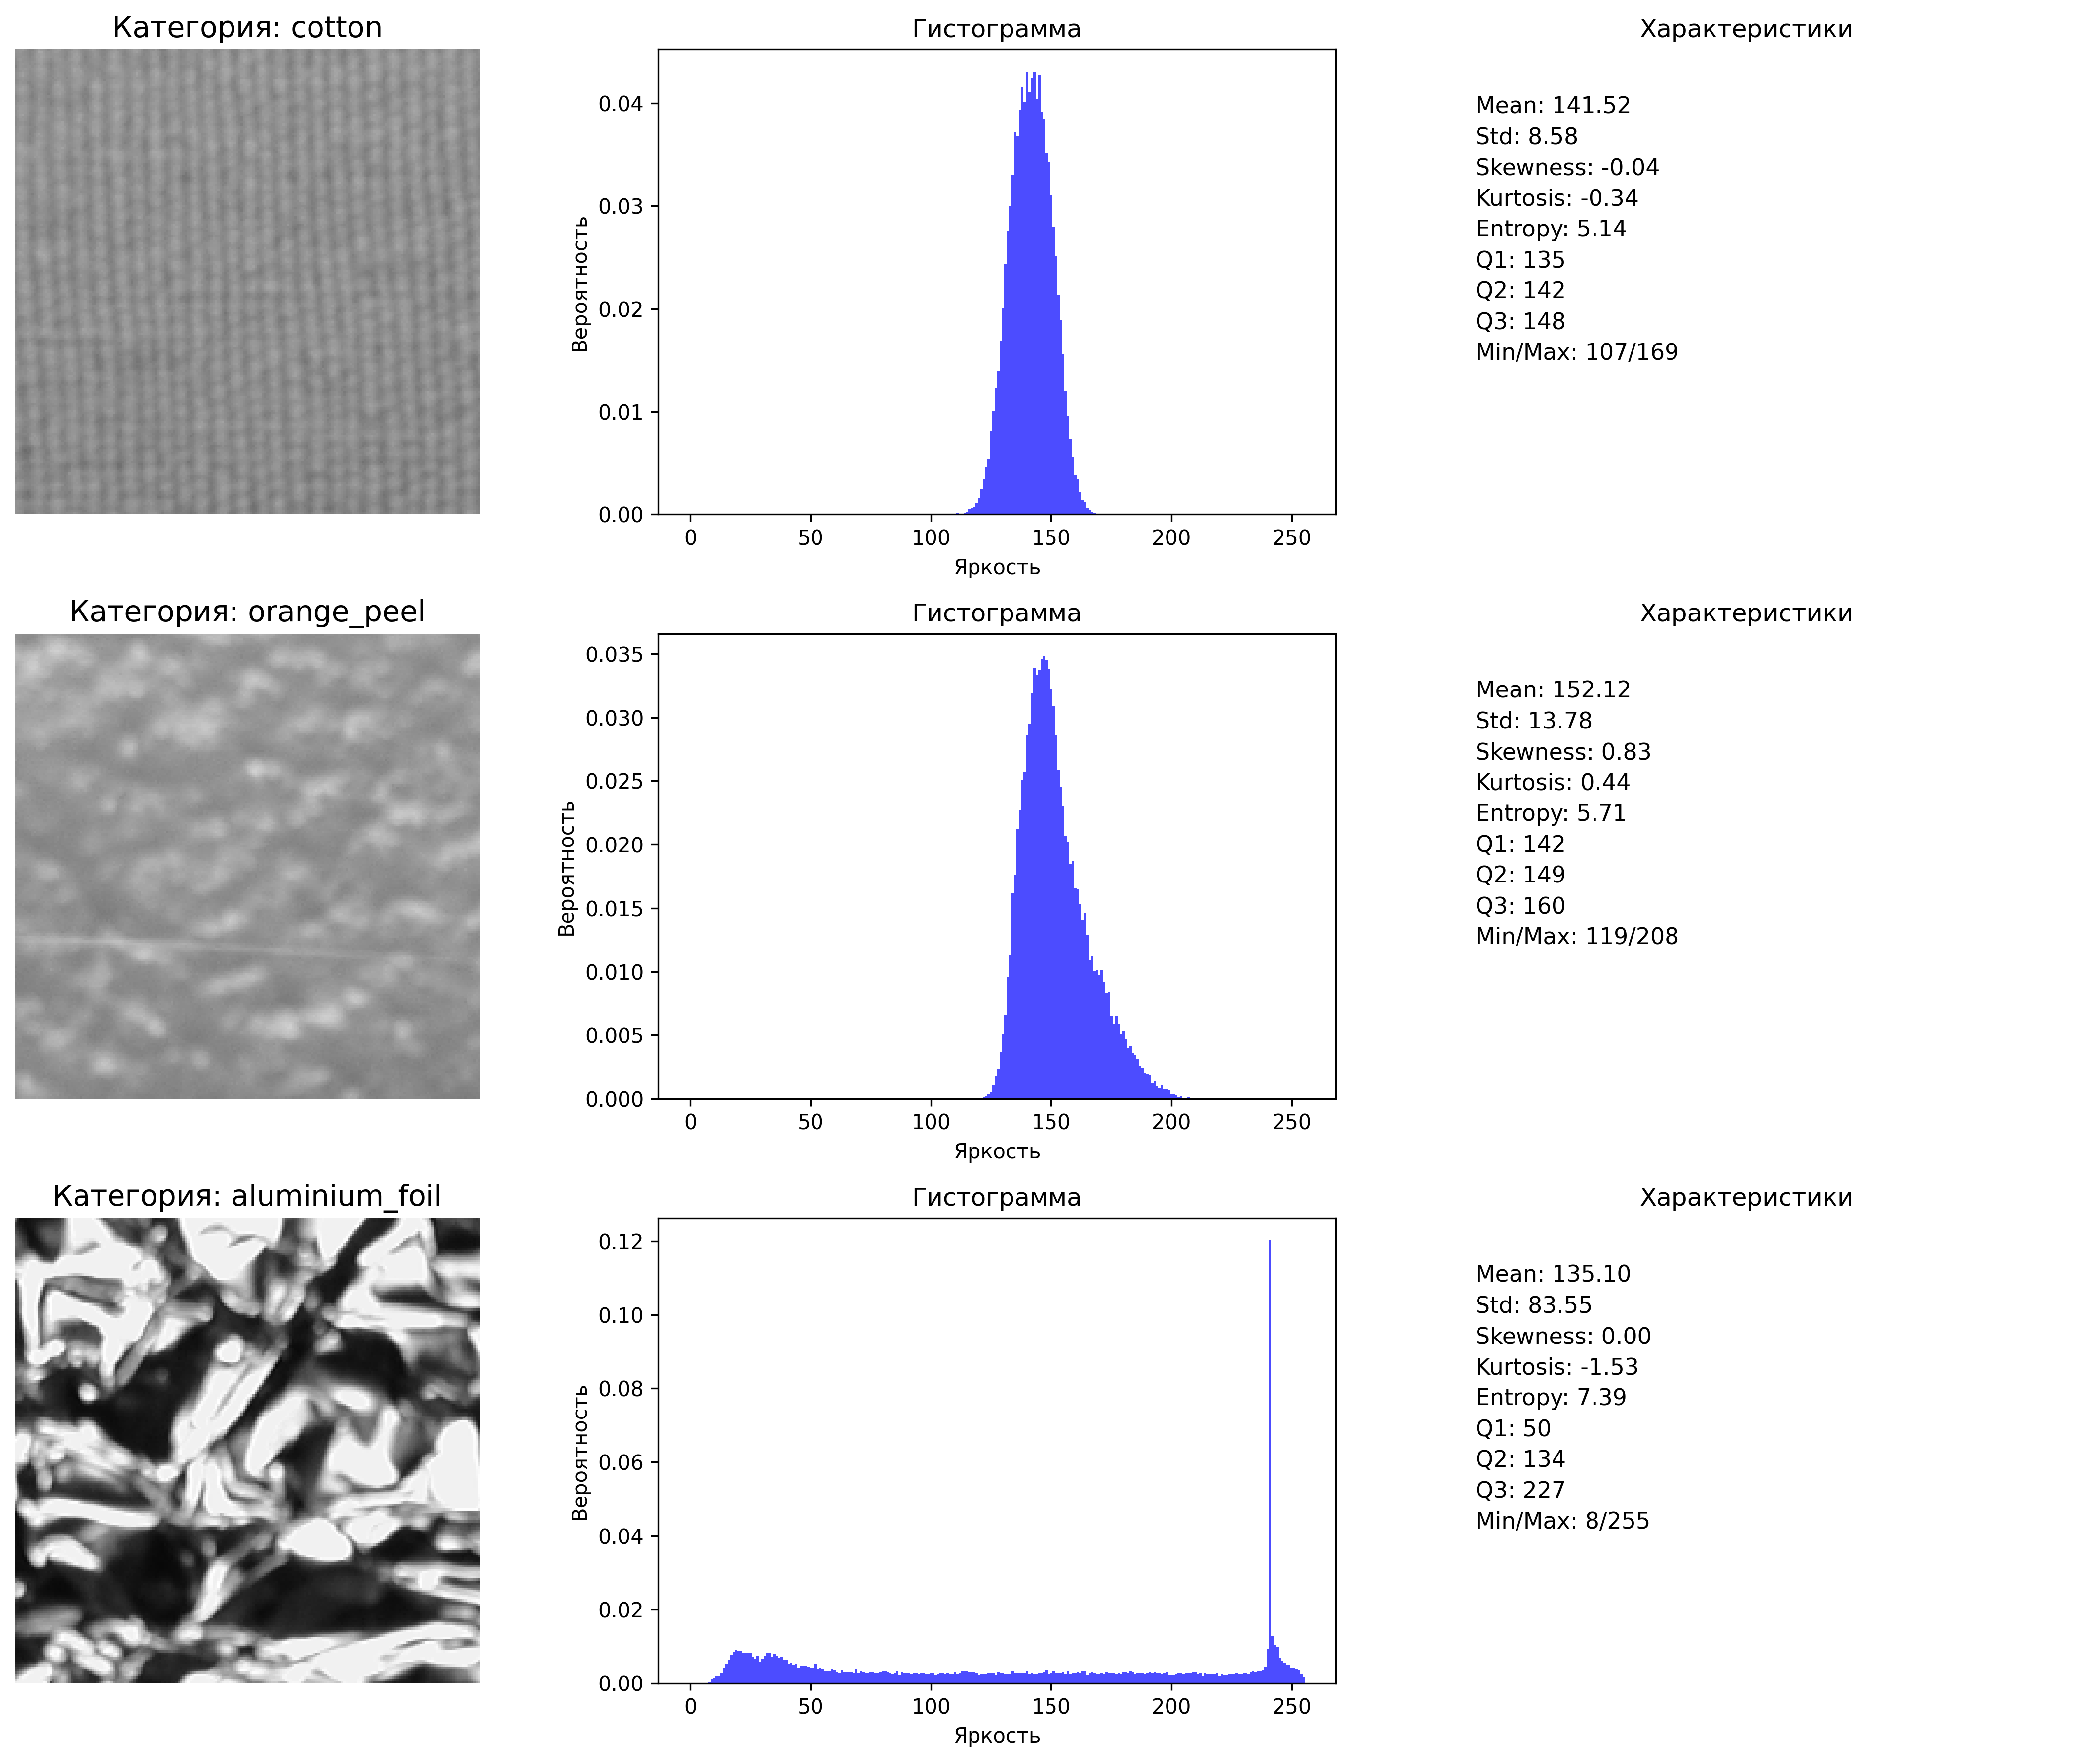

Гистограммы обработаны и выведены

2. LAWS ХАРАКТЕРИСТИКИ


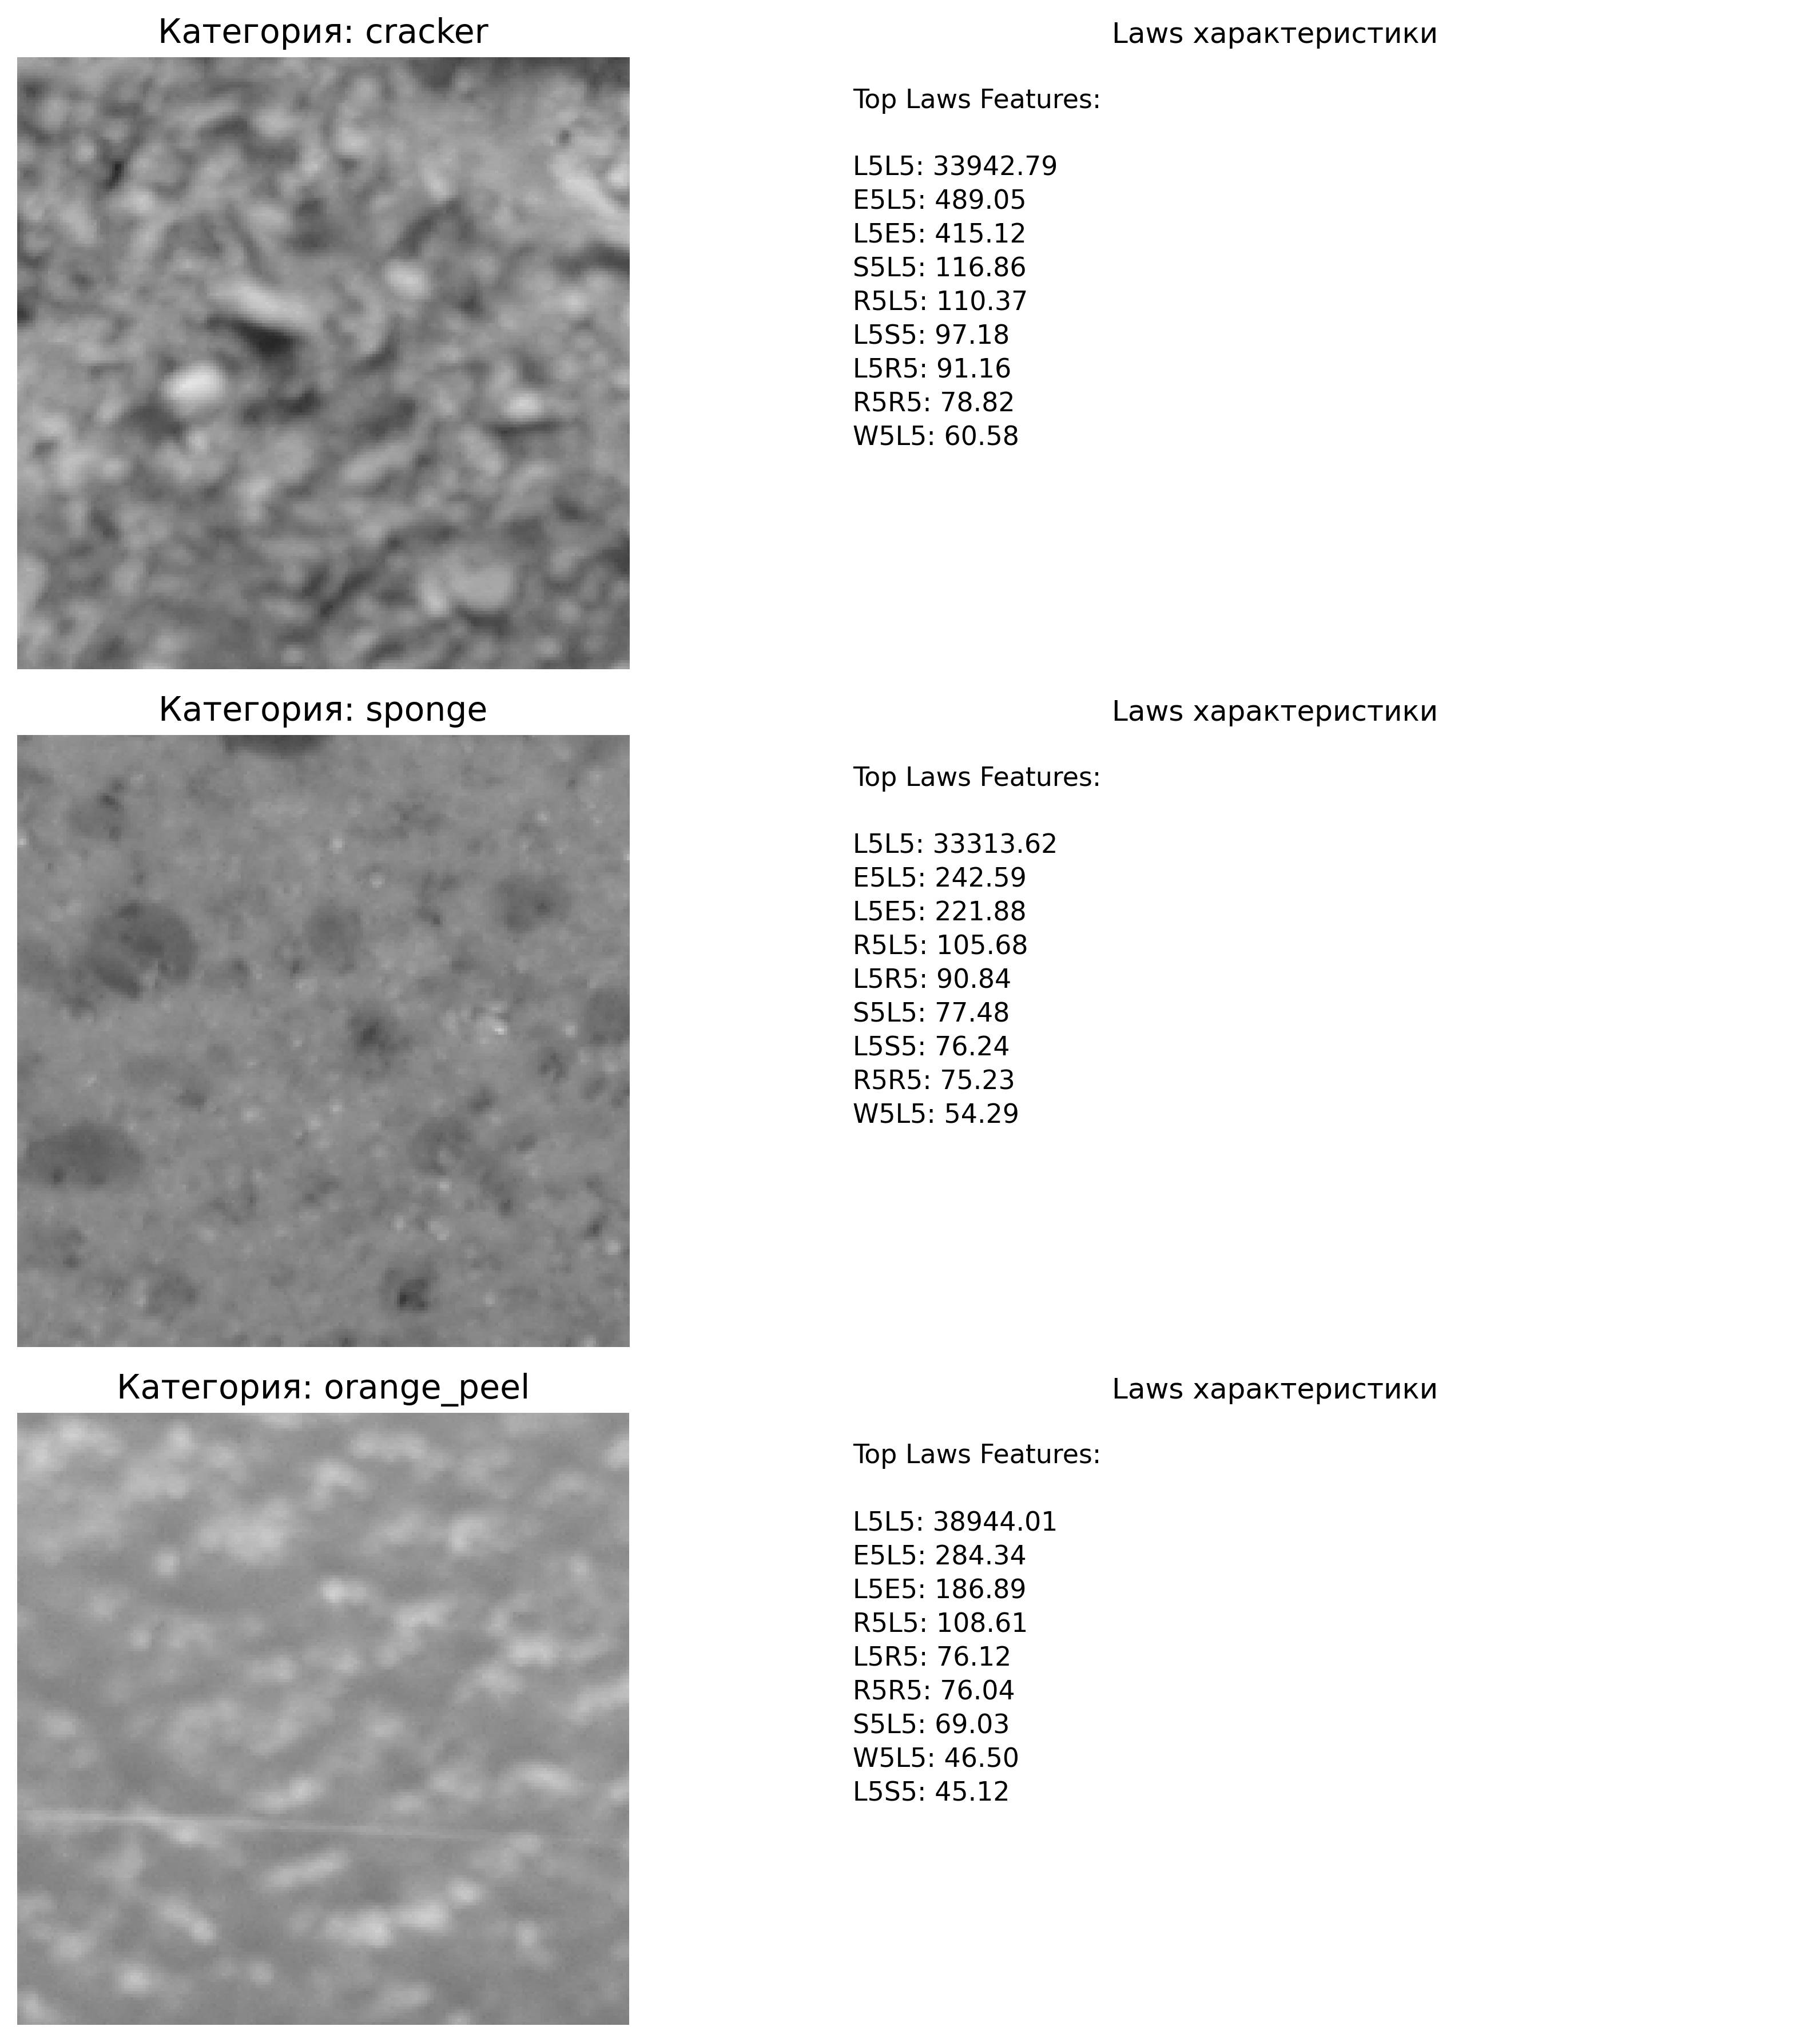

Laws характеристики обработаны и выведены

3. GLCM ХАРАКТЕРИСТИКИ


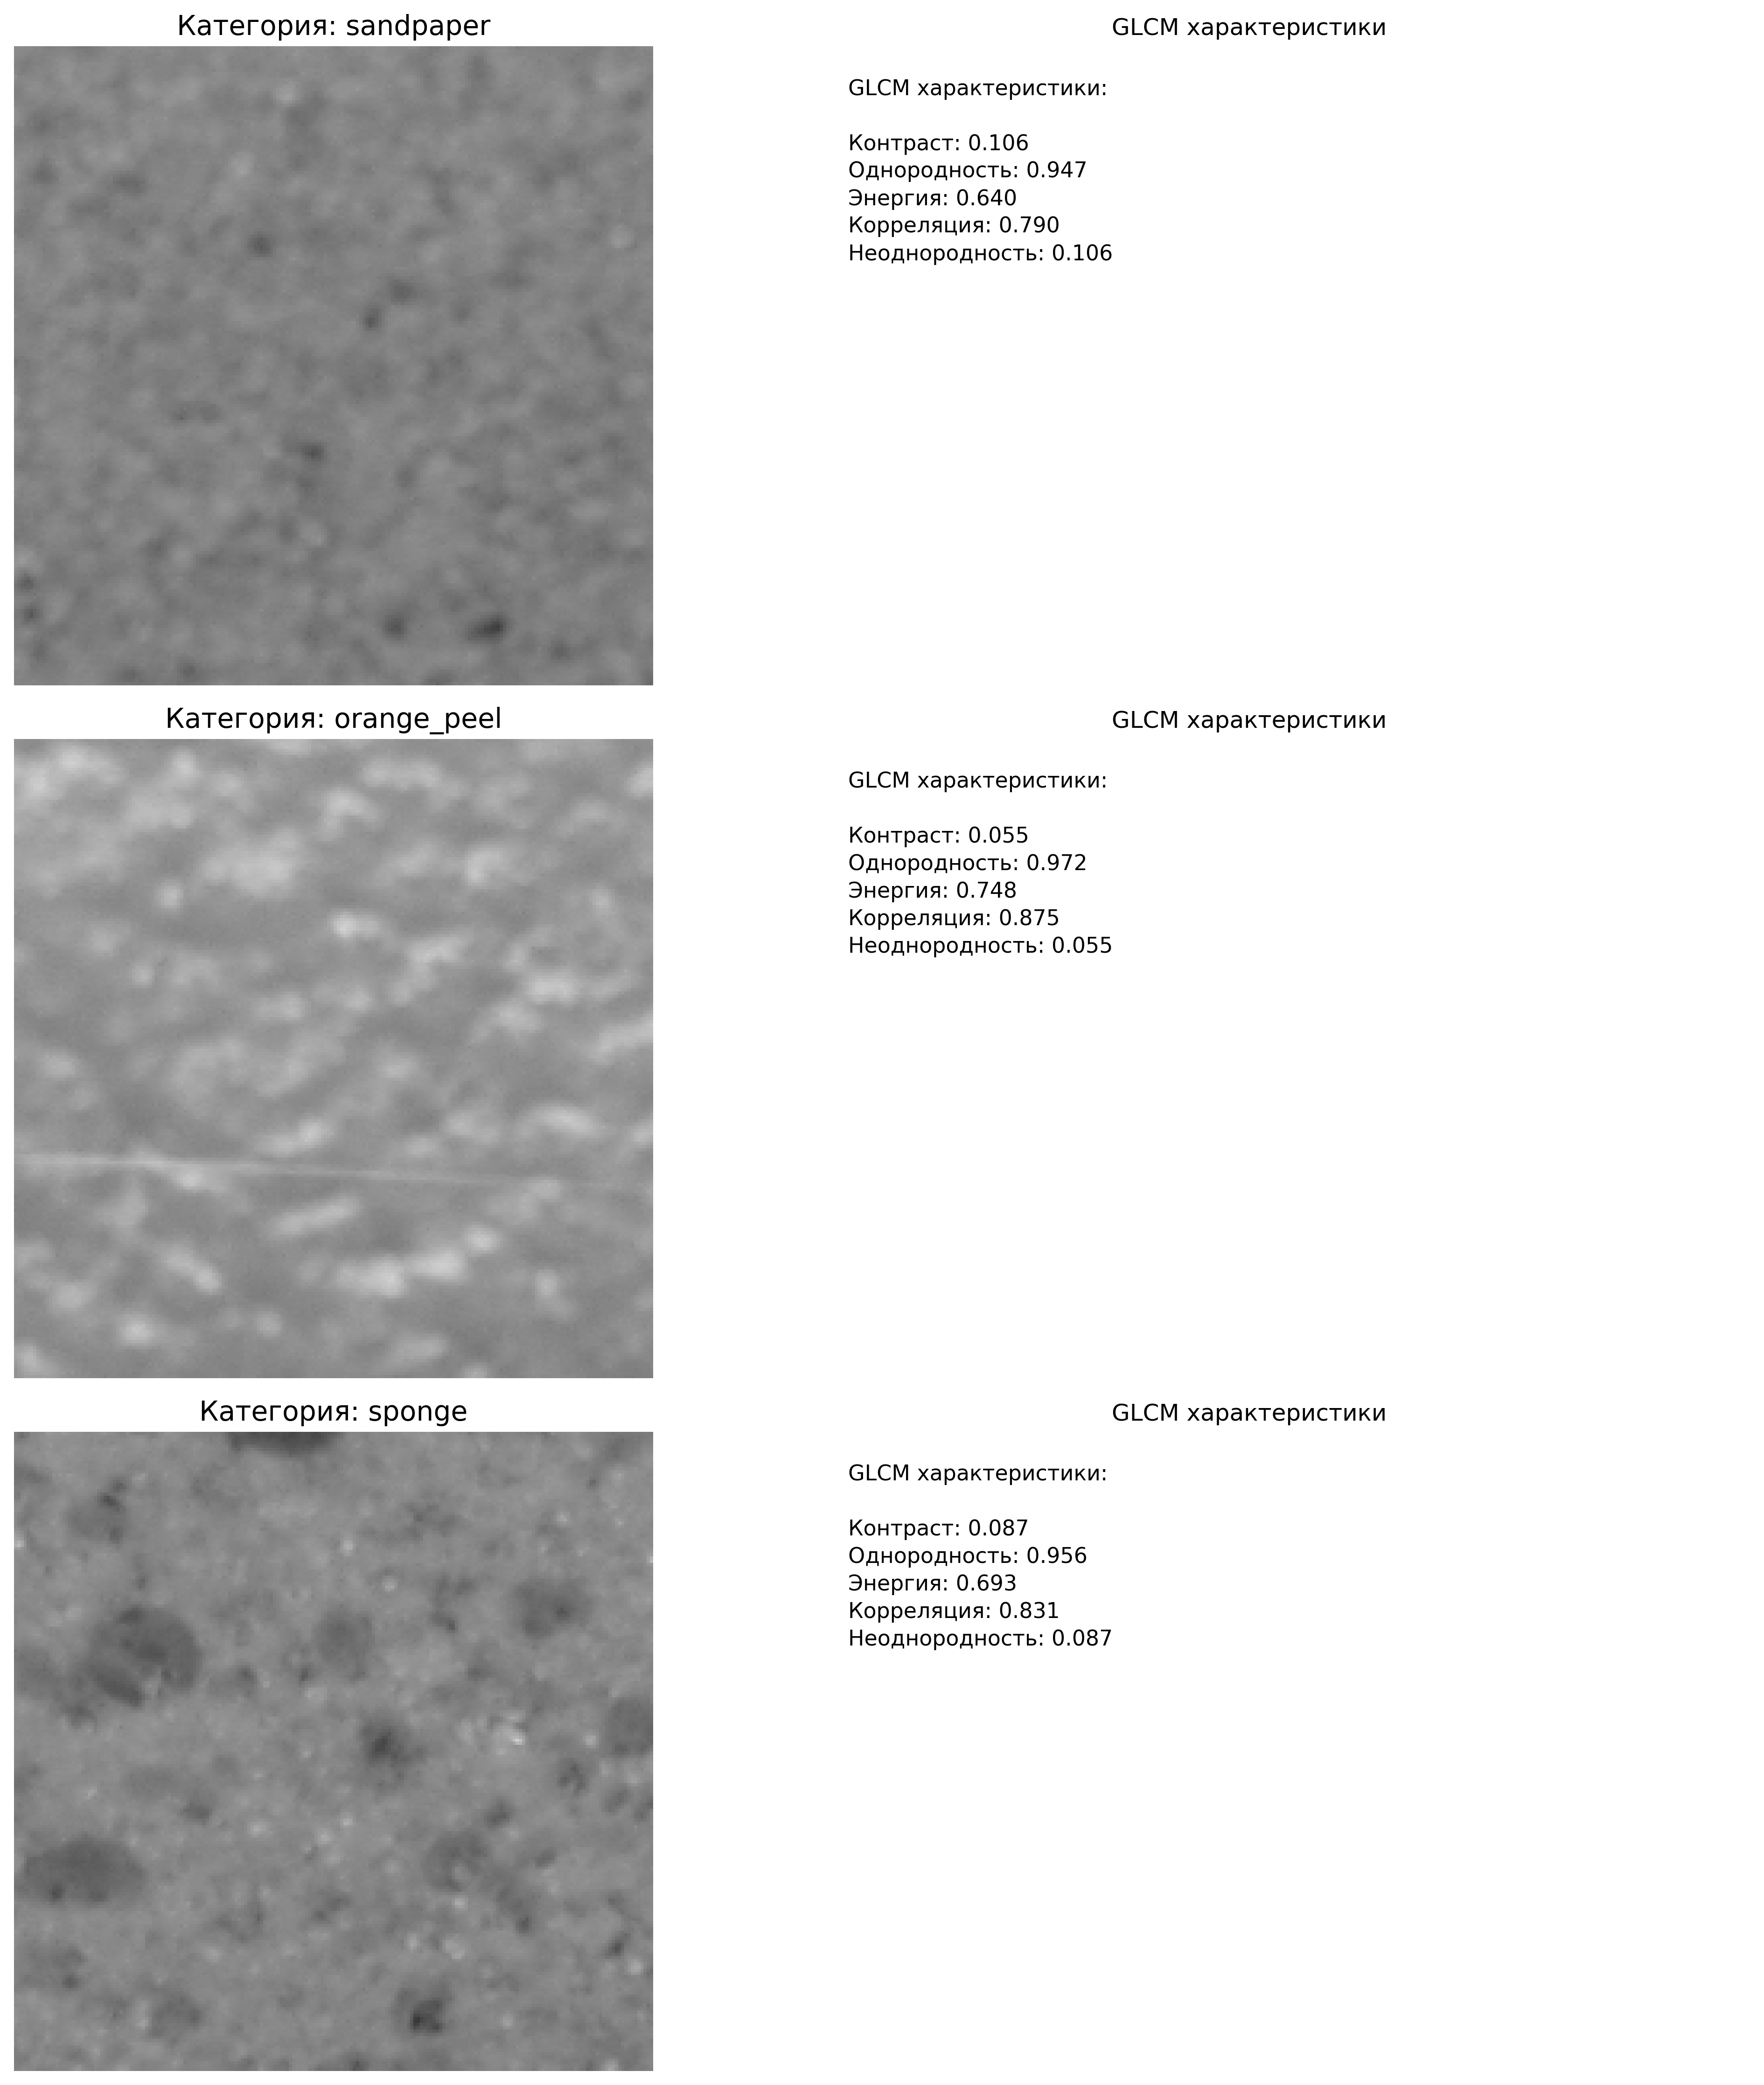

GLCM характеристики обработаны и выведены

ОБУЧЕНИЕ КЛАССИФИКАТОРОВ
Обработано 0/810 изображений
Обработано 50/810 изображений
Обработано 100/810 изображений
Обработано 150/810 изображений
Обработано 200/810 изображений
Обработано 250/810 изображений
Обработано 300/810 изображений
Обработано 350/810 изображений
Обработано 400/810 изображений
Обработано 450/810 изображений
Обработано 500/810 изображений
Обработано 550/810 изображений
Обработано 600/810 изображений
Обработано 650/810 изображений
Обработано 700/810 изображений
Обработано 750/810 изображений
Обработано 800/810 изображений
Размеры данных:
Histogram: (810, 10)
Laws: (810, 25)
GLCM: (810, 40)
Количество классов: 10

HISTOGRAM
kNN
                precision    recall  f1-score   support

aluminium_foil       0.95      1.00      0.98        20
   brown_bread       0.90      0.95      0.93        20
      corduroy       0.58      0.70      0.64        20
        cotton       0.55      0.52      0.54        21
       cracker      

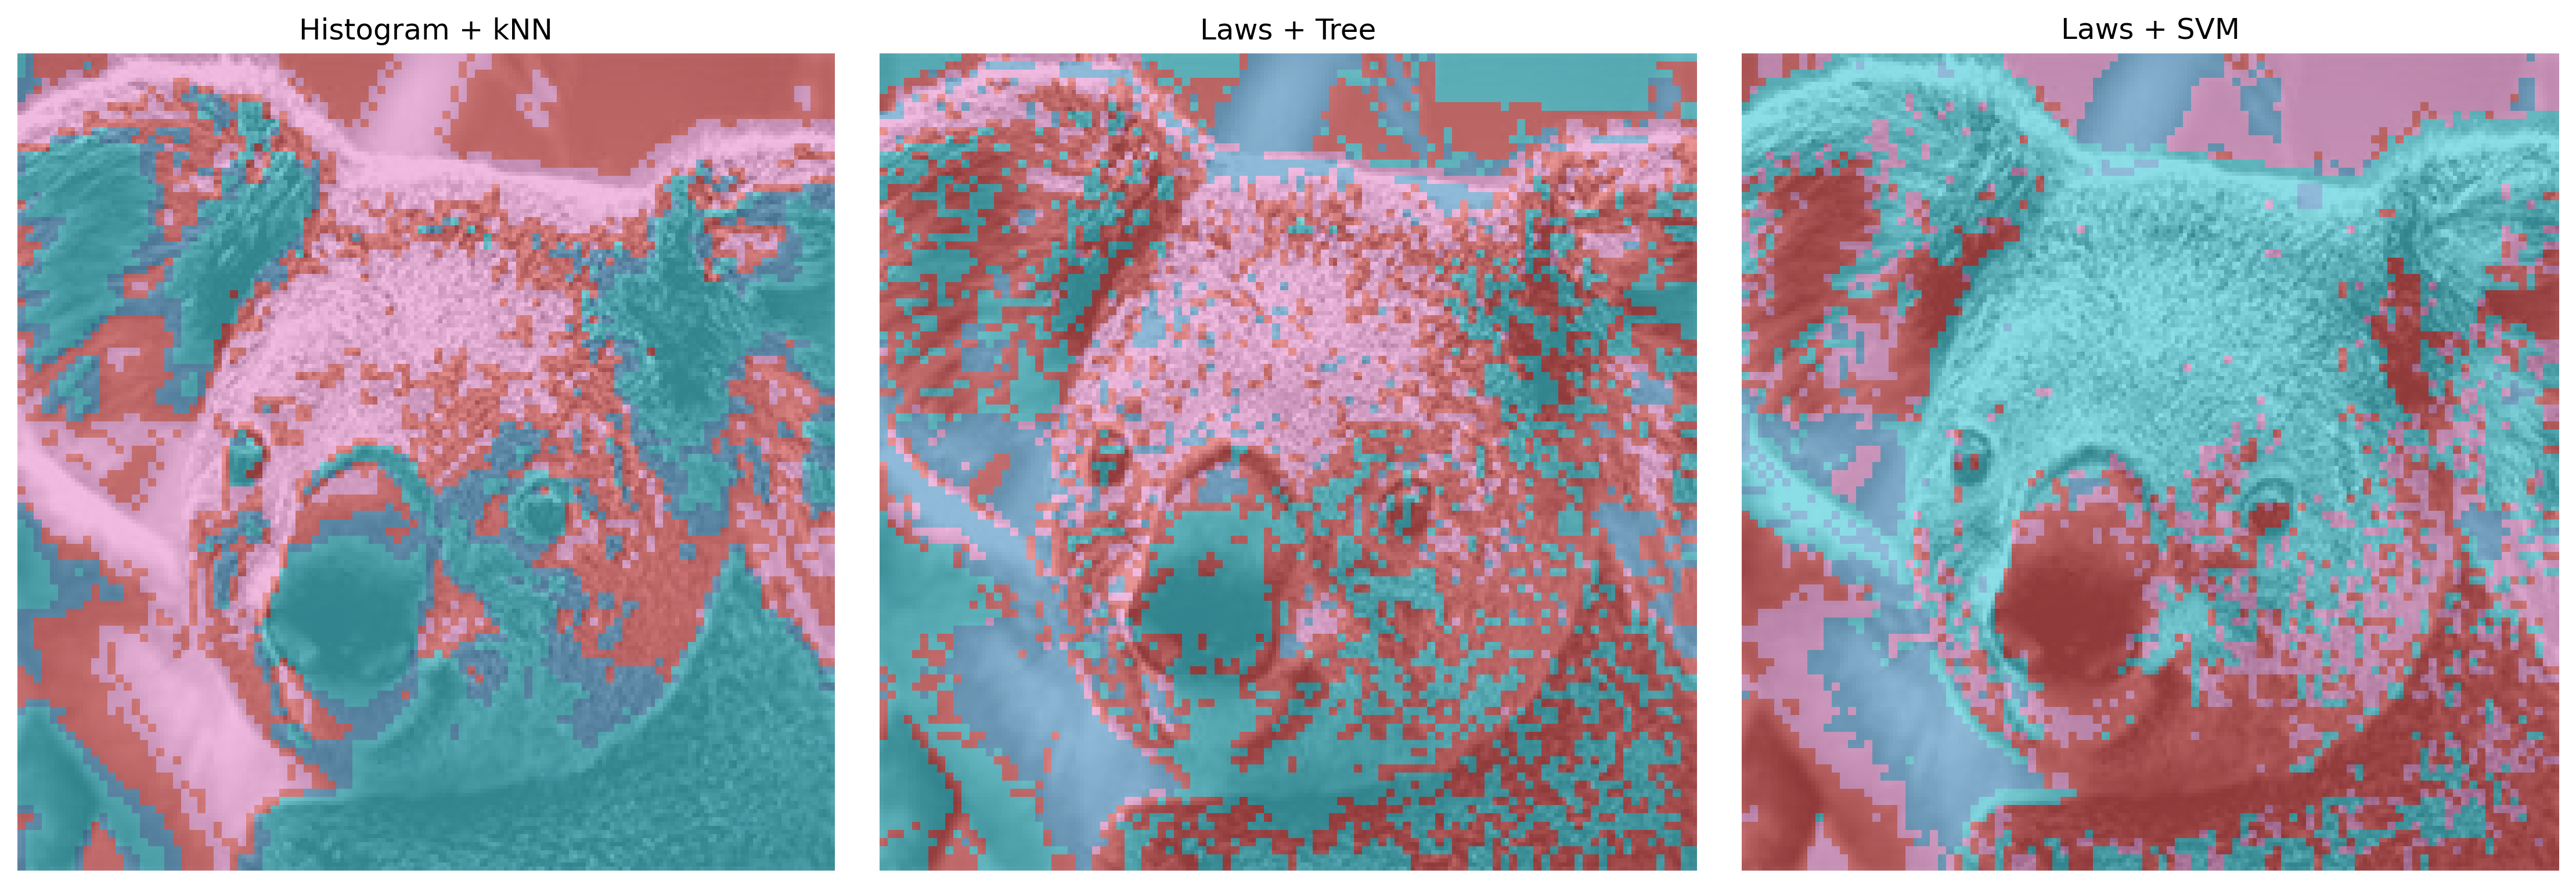

Результаты сегментации выведены выше

РУЧНАЯ РАЗМЕТКА И СРАВНЕНИЕ


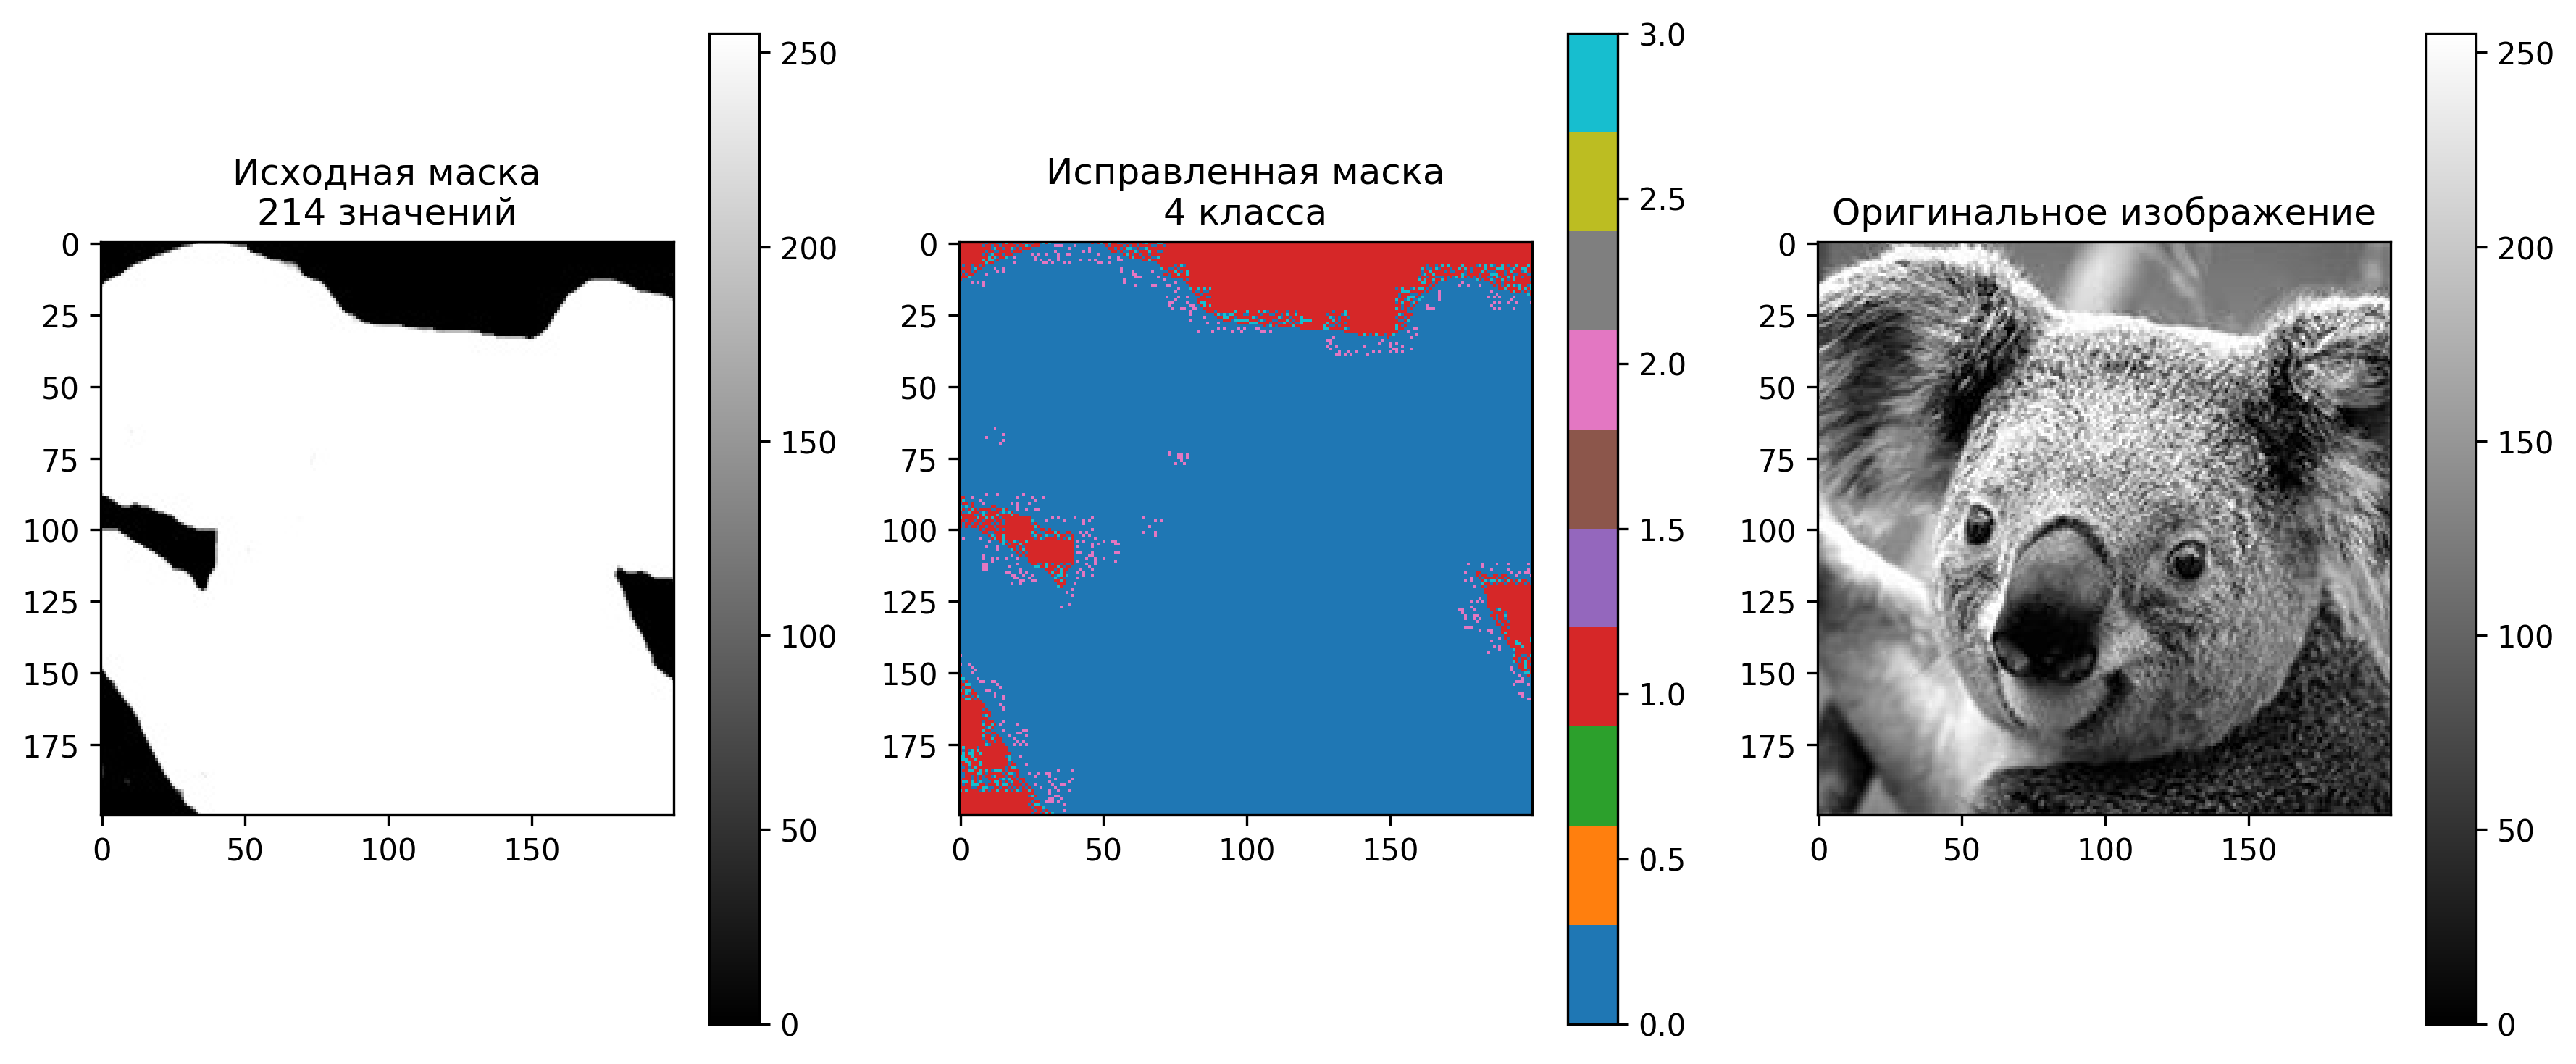

Сравнение масок

Сравнение для Histogram_kNN:
Размер ручной маски: (200, 200)
Размер предсказанной маски: (200, 200)
Размер после ресайза: (200, 200)
  Предсказанный класс 0 -> Ручной класс 0
  Предсказанный класс 1 -> Ручной класс 0
  Предсказанный класс 2 -> Ручной класс 0
  Предсказанный класс 3 -> Ручной класс 0


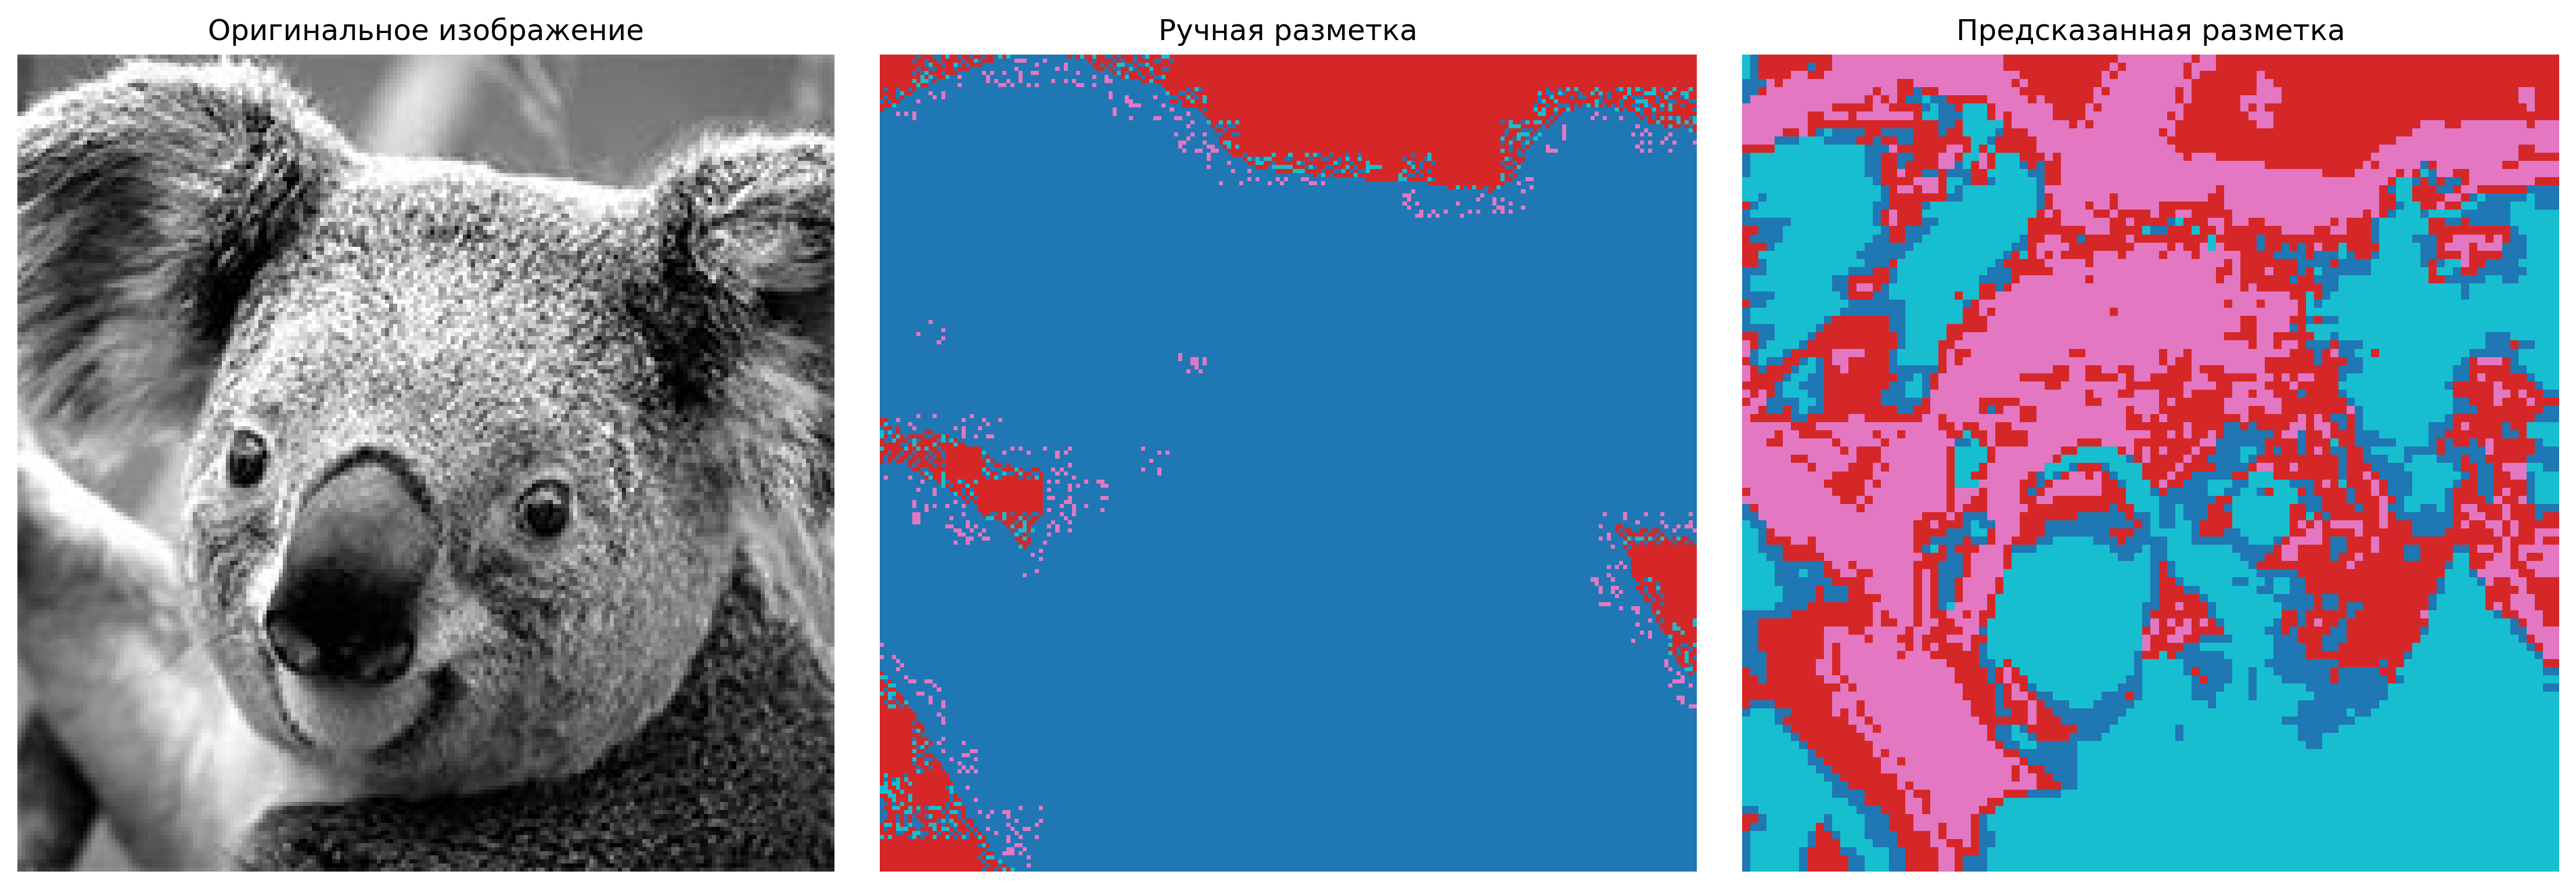

Итог для Histogram_kNN: 87.1% правильных пикселей

Сравнение для Laws_Tree:
Размер ручной маски: (200, 200)
Размер предсказанной маски: (200, 200)
Размер после ресайза: (200, 200)
  Предсказанный класс 0 -> Ручной класс 0
  Предсказанный класс 1 -> Ручной класс 0
  Предсказанный класс 2 -> Ручной класс 0
  Предсказанный класс 3 -> Ручной класс 0


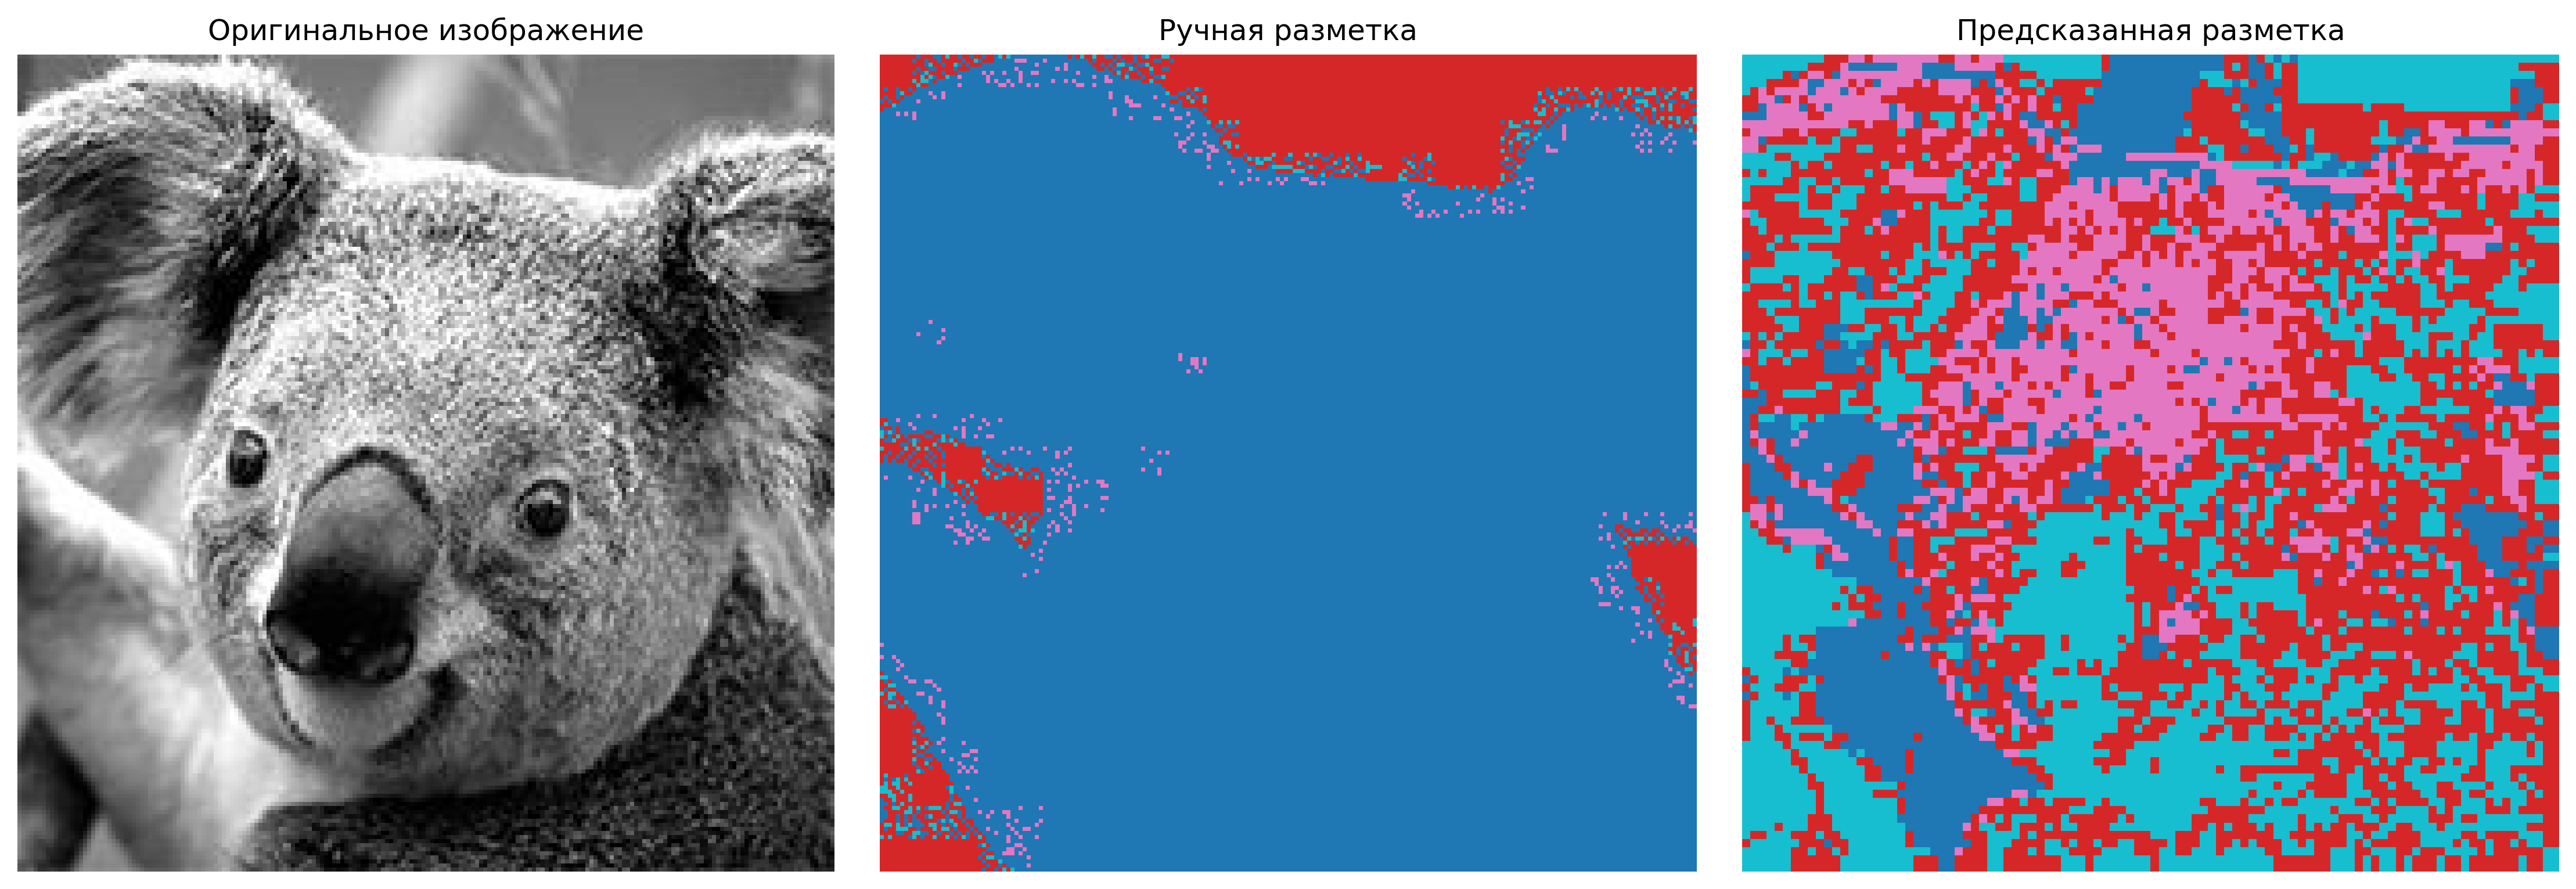

Итог для Laws_Tree: 87.1% правильных пикселей

Сравнение для Laws_SVM:
Размер ручной маски: (200, 200)
Размер предсказанной маски: (200, 200)
Размер после ресайза: (200, 200)
  Предсказанный класс 0 -> Ручной класс 0
  Предсказанный класс 1 -> Ручной класс 0
  Предсказанный класс 2 -> Ручной класс 0
  Предсказанный класс 3 -> Ручной класс 0


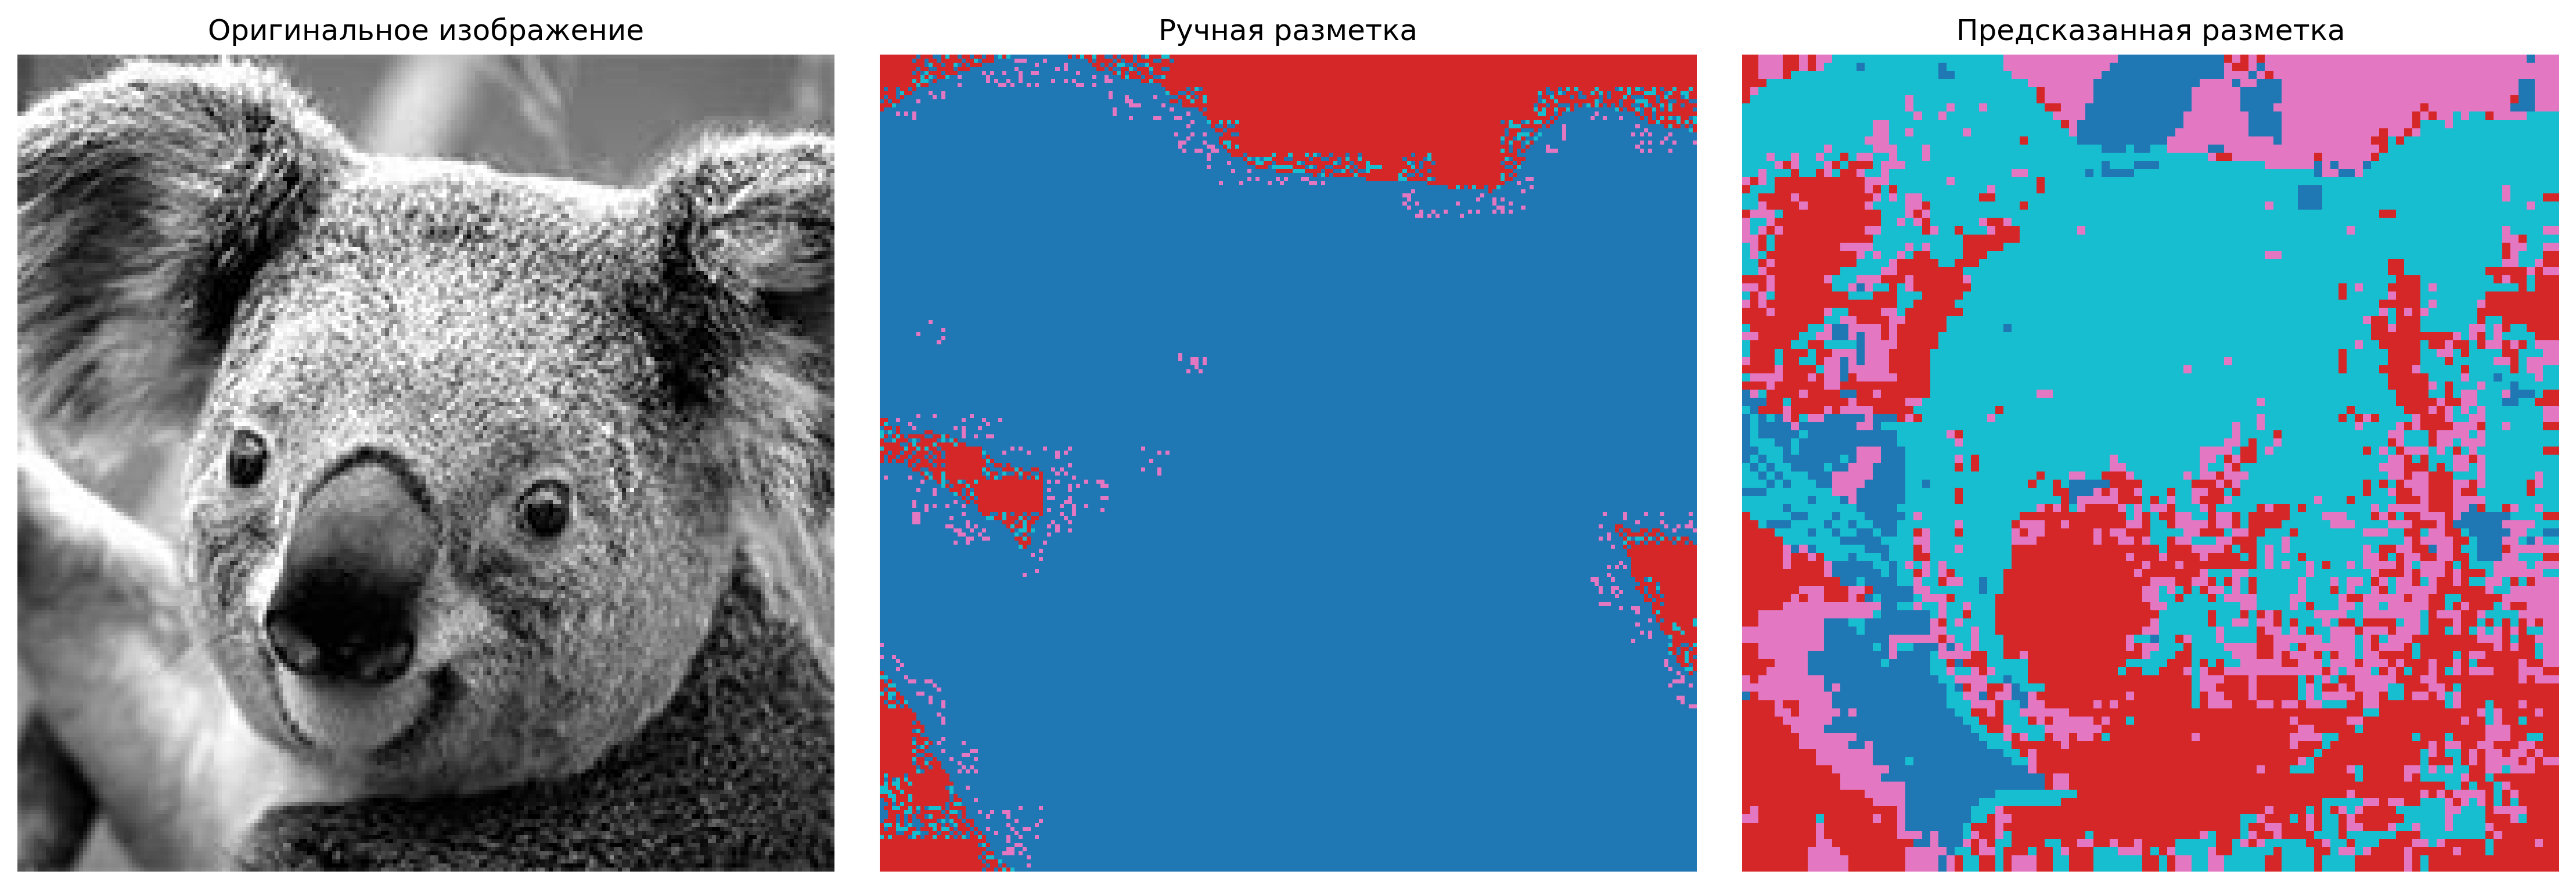

Итог для Laws_SVM: 87.1% правильных пикселей

Анализ успешно завершен! Создано 8 изображений:
   - histogram_analysis
   - laws_analysis
   - glcm_analysis
   - segmentation_results
   - manual_mask_comparison
   - comparison_Histogram_kNN
   - comparison_Laws_Tree
   - comparison_Laws_SVM


In [10]:
if __name__ == "__main__":
    results = main()